In [ ]:
# Install the necessary libraries
!pip install transformers torch
!pip install emot
!pip install spacy
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 2.1 MB/s eta 0:00:00
2023-11-25 20:57:46.488798: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-25 20:57:46.488867: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-25 20:57:46.488897: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 20:57:46.498446: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with th

In [ ]:
# Sentiment Analysis of Naira Redesign 2023 Policy and Nigerian Presidential Elections
import nltk
import spacy
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
import numpy as np
import pandas as pd
from imblearn.under_sampling import ClusterCentroids
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_curve, recall_score, precision_score
import warnings

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# Set the limits for Pandas Dataframe display to avoid potential system freeze
pd.set_option("display.max_rows", 15)
pd.set_option("display.max_columns", 15)
pd.set_option('display.max_colwidth', 40)

warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## Loading the dataset

In [ ]:
# Loading the scrapped twitter dataset into a Panda DataFrame
naira_data = pd.read_excel("naira_tweets.xlsx")
election_data = pd.read_excel("election_tweets.xlsx")

In [ ]:
# Keywords related to the Naira policy

policy_keywords = ["cash", "bank", "atm", "pos", "cbn", "cbn governor", "cashswap",
                   "deadline", "extension", "naira crisis", "buy", "new note", "old note",
                   "new naira", "old naira", "deposit", "withdraw", "currency",
                   "naira", "money", "emefiele", "redesign", "design", "policy", "policies"]

In [ ]:
election_data

,tweet_id,User_Location,New location,Text content,Tweet Date time,impression,like_count,reply_count,retweet_count,quote_count,tweet_url,KEYWORDS
0,1606413344822490112,"Lagos, Nigeria","Lagos, Nigeria",@jidesanwoolu E no go better for APC...,2022-12-23 22:16:01+00:00,356.0,3,0,0,0,https://twitter.com/UKASON5/status/1...,APC
1,1606413005939510016,"Benin, Nigeria","Benin city, Nigeria",@06trigga @dumdozzy @jarmari01 @Mari...,2022-12-23 22:14:40+00:00,16.0,0,0,0,0,https://twitter.com/anembaben/status...,APC
2,1606412654368659968,"Enugu, Nigeria","Enugu, Nigeria",This is why APC must never return. T...,2022-12-23 22:13:17+00:00,4669.0,18,1,15,1,https://twitter.com/asemota/status/1...,APC
3,1606412262587219968,"Akure, Nigeria","Akure, Nigeria",Two people God will punish this peri...,2022-12-23 22:11:43+00:00,307.0,4,0,2,0,https://twitter.com/DeraOnuh/status/...,APC
4,1606410662388930048,"Ilorin, Nigeria","Ilorin, Nigeria",@Better_Kaduna @elrufai @KCTA_KD @Ha...,2022-12-23 22:05:22+00:00,239.0,4,0,0,0,https://twitter.com/ChuksRaph2020/st...,APC
...,...,...,...,...,...,...,...,...,...,...,...,...
215207,1605706813537760000,"Zaria, Nigeria","Bauchi, Nigeria",@Canbini @JoyUkaha @GazetteNGR @Pete...,2022-12-21 23:28:31+00:00,26.0,0,0,0,0,https://twitter.com/BishopEze7/statu...,APC
215208,1606055194198000128,"Zaria, Nigeria","Bauchi, Nigeria","BREAKING: ARISE TV, ThisDay Publishe...",2022-12-22 22:32:52+00:00,25.0,0,0,0,0,https://twitter.com/TheNigerianBar/s...,APC
215209,1606413949125139968,"Zaria, Nigeria","Bauchi, Nigeria",@kingkhone4real @GoziconC Not by IPO...,2022-12-23 22:18:25+00:00,34.0,0,1,0,0,https://twitter.com/ezicandid/status...,APC
215210,704730131508633600,"Zaria, Nigeria","Bauchi, Nigeria",Rt. Hon. \n@IsaAshiruKudan\n has rec...,2022-12-25 19:59:57+00:00,131.0,5,0,4,0,https://twitter.com/Samsongalaaxy/st...,NNPP


In [ ]:
election_data = election_data.drop(columns=['User_Location'])
election_data = election_data.rename(columns={"New location": "User_Location"})
election_data

,tweet_id,User_Location,Text content,Tweet Date time,impression,like_count,reply_count,retweet_count,quote_count,tweet_url,KEYWORDS
0,1606413344822490112,"Lagos, Nigeria",@jidesanwoolu E no go better for APC...,2022-12-23 22:16:01+00:00,356.0,3,0,0,0,https://twitter.com/UKASON5/status/1...,APC
1,1606413005939510016,"Benin city, Nigeria",@06trigga @dumdozzy @jarmari01 @Mari...,2022-12-23 22:14:40+00:00,16.0,0,0,0,0,https://twitter.com/anembaben/status...,APC
2,1606412654368659968,"Enugu, Nigeria",This is why APC must never return. T...,2022-12-23 22:13:17+00:00,4669.0,18,1,15,1,https://twitter.com/asemota/status/1...,APC
3,1606412262587219968,"Akure, Nigeria",Two people God will punish this peri...,2022-12-23 22:11:43+00:00,307.0,4,0,2,0,https://twitter.com/DeraOnuh/status/...,APC
4,1606410662388930048,"Ilorin, Nigeria",@Better_Kaduna @elrufai @KCTA_KD @Ha...,2022-12-23 22:05:22+00:00,239.0,4,0,0,0,https://twitter.com/ChuksRaph2020/st...,APC
...,...,...,...,...,...,...,...,...,...,...,...
215207,1605706813537760000,"Bauchi, Nigeria",@Canbini @JoyUkaha @GazetteNGR @Pete...,2022-12-21 23:28:31+00:00,26.0,0,0,0,0,https://twitter.com/BishopEze7/statu...,APC
215208,1606055194198000128,"Bauchi, Nigeria","BREAKING: ARISE TV, ThisDay Publishe...",2022-12-22 22:32:52+00:00,25.0,0,0,0,0,https://twitter.com/TheNigerianBar/s...,APC
215209,1606413949125139968,"Bauchi, Nigeria",@kingkhone4real @GoziconC Not by IPO...,2022-12-23 22:18:25+00:00,34.0,0,1,0,0,https://twitter.com/ezicandid/status...,APC
215210,704730131508633600,"Bauchi, Nigeria",Rt. Hon. \n@IsaAshiruKudan\n has rec...,2022-12-25 19:59:57+00:00,131.0,5,0,4,0,https://twitter.com/Samsongalaaxy/st...,NNPP


In [ ]:
# Filter tweets containing both policy and election keywords
policy_tweets = election_data[election_data['Text content'].apply(lambda x: any(keyword in str(x) for keyword in policy_keywords))]


In [ ]:
policy_tweets

,tweet_id,User_Location,Text content,Tweet Date time,impression,like_count,reply_count,retweet_count,quote_count,tweet_url,KEYWORDS
1,1606413005939510016,"Benin city, Nigeria",@06trigga @dumdozzy @jarmari01 @Mari...,2022-12-23 22:14:40+00:00,16.0,0,0,0,0,https://twitter.com/anembaben/status...,APC
2,1606412654368659968,"Enugu, Nigeria",This is why APC must never return. T...,2022-12-23 22:13:17+00:00,4669.0,18,1,15,1,https://twitter.com/asemota/status/1...,APC
21,1606778061768339968,"Benin city, Nigeria",@potentialprof11 @Sadiyahamza41 Who ...,2022-12-24 22:25:17+00:00,104.0,2,0,0,0,https://twitter.com/EmekaNkwuaku/sta...,APC
22,1606777057639529984,"Kano,Nigeria",@SaharaReporters @officialEFCC @Offi...,2022-12-24 22:21:17+00:00,647.0,1,1,0,0,https://twitter.com/Joy19962458/stat...,APC
25,1607144334368839936,"Ekiti, Nigeria",@Ch12206535Chris @Makavelli275 ðŸ˜‚ð...,2022-12-25 22:40:43+00:00,109.0,1,0,0,0,https://twitter.com/Gruka001/status/...,APC
...,...,...,...,...,...,...,...,...,...,...,...
215185,785090725,"Yobe, Nigeria",Many Nigerians i suppose are not wel...,2023-01-02 13:57:13+00:00,377.0,1,0,2,0,https://twitter.com/muky_zanna/statu...,BVAS
215195,1605706969557250048,"Zamfara, Nigeria",@abikedabiri @officialABAT @Official...,2022-12-21 23:29:08+00:00,10.0,0,0,0,0,https://twitter.com/Badejo2007/statu...,APC
215205,2931066720,"Bauchi, Nigeria",I am grateful to God for grace of an...,2023-02-17 23:51:19+00:00,645.0,11,2,2,0,https://twitter.com/olatunjiolumid3/...,BVAS
215206,2931066720,"Bauchi, Nigeria",I am grateful to God for grace of an...,2023-02-17 23:51:19+00:00,645.0,11,2,2,0,https://twitter.com/olatunjiolumid3/...,INEC


In [ ]:
naira_data

,tweet_id,User_Location,Tweet_Content,Tweet_DateTime,impression,like_count,reply_count,retweet_count,quote_count,tweet_url,KEYWORD
0,1609699208541659904,NaN,DISTURBING NEWS: Heavily Armed Assas...,2023-01-01 23:52:52+00:00,498.0,1,0,0,0,https://twitter.com/ZamfaraR/status/...,CBN
1,1609698822233479936,NaN,@mrojo88 @ademolababaD @dmightyangel...,2023-01-01 23:51:20+00:00,32.0,0,0,0,0,https://twitter.com/baTeeatus/status...,CBN
2,1609697932235729920,NaN,We offer affordable HPLC for testing...,2023-01-01 23:47:48+00:00,103.0,1,0,1,0,https://twitter.com/cannabistest1/st...,CBN
3,1609689801212689920,NaN,Still On CBN And The Cashless Econom...,2023-01-01 23:15:29+00:00,12.0,0,0,0,0,https://twitter.com/OpinionNigeria/s...,CBN
4,1609684243650579968,NaN,CBN Retains Benchmark Interest Rate ...,2023-01-01 22:53:24+00:00,11.0,0,0,0,0,https://twitter.com/PilotAfrican/sta...,CBN
...,...,...,...,...,...,...,...,...,...,...,...
78789,502052332,"Lagos, Nigeria",APC urges President Buhari to respec...,2023-02-19 23:00:32+00:00,8.0,0,0,0,0,https://twitter.com/olumidagreat/sta...,NEW NAIRA
78790,1519684156384591872,NaN,There are possibilities of FAKE new ...,2023-02-19 23:00:08+00:00,19.0,0,0,1,0,https://twitter.com/manji_dawam/stat...,NEW NAIRA
78791,904752027946897408,Nigeria,@SaharaReporters Please what will ha...,2023-02-19 22:58:52+00:00,264.0,0,1,0,0,https://twitter.com/Fred_lugardo/sta...,NEW NAIRA
78792,1552461368502226944,"Lagos, Nigeria",What's the latest update\n🙏\n\nAbout...,2023-02-19 22:57:16+00:00,32.0,0,0,0,0,https://twitter.com/Sonofabalaka/sta...,NEW NAIRA


In [ ]:
naira_data = naira_data.rename(columns={"Tweet_Content": "Text content", "Tweet_DateTime": "Tweet Date time", "KEYWORD": "KEYWORDS"})
naira_data

,tweet_id,User_Location,Text content,Tweet Date time,impression,like_count,reply_count,retweet_count,quote_count,tweet_url,KEYWORDS
0,1609699208541659904,NaN,DISTURBING NEWS: Heavily Armed Assas...,2023-01-01 23:52:52+00:00,498.0,1,0,0,0,https://twitter.com/ZamfaraR/status/...,CBN
1,1609698822233479936,NaN,@mrojo88 @ademolababaD @dmightyangel...,2023-01-01 23:51:20+00:00,32.0,0,0,0,0,https://twitter.com/baTeeatus/status...,CBN
2,1609697932235729920,NaN,We offer affordable HPLC for testing...,2023-01-01 23:47:48+00:00,103.0,1,0,1,0,https://twitter.com/cannabistest1/st...,CBN
3,1609689801212689920,NaN,Still On CBN And The Cashless Econom...,2023-01-01 23:15:29+00:00,12.0,0,0,0,0,https://twitter.com/OpinionNigeria/s...,CBN
4,1609684243650579968,NaN,CBN Retains Benchmark Interest Rate ...,2023-01-01 22:53:24+00:00,11.0,0,0,0,0,https://twitter.com/PilotAfrican/sta...,CBN
...,...,...,...,...,...,...,...,...,...,...,...
78789,502052332,"Lagos, Nigeria",APC urges President Buhari to respec...,2023-02-19 23:00:32+00:00,8.0,0,0,0,0,https://twitter.com/olumidagreat/sta...,NEW NAIRA
78790,1519684156384591872,NaN,There are possibilities of FAKE new ...,2023-02-19 23:00:08+00:00,19.0,0,0,1,0,https://twitter.com/manji_dawam/stat...,NEW NAIRA
78791,904752027946897408,Nigeria,@SaharaReporters Please what will ha...,2023-02-19 22:58:52+00:00,264.0,0,1,0,0,https://twitter.com/Fred_lugardo/sta...,NEW NAIRA
78792,1552461368502226944,"Lagos, Nigeria",What's the latest update\n🙏\n\nAbout...,2023-02-19 22:57:16+00:00,32.0,0,0,0,0,https://twitter.com/Sonofabalaka/sta...,NEW NAIRA


In [ ]:
# Concatenate the dataframes along the rows (axis=0)
data = pd.concat([naira_data, policy_tweets], ignore_index=True)

In [ ]:
data

,tweet_id,User_Location,Text content,Tweet Date time,impression,like_count,reply_count,retweet_count,quote_count,tweet_url,KEYWORDS
0,1609699208541659904,NaN,DISTURBING NEWS: Heavily Armed Assas...,2023-01-01 23:52:52+00:00,498.0,1,0,0,0,https://twitter.com/ZamfaraR/status/...,CBN
1,1609698822233479936,NaN,@mrojo88 @ademolababaD @dmightyangel...,2023-01-01 23:51:20+00:00,32.0,0,0,0,0,https://twitter.com/baTeeatus/status...,CBN
2,1609697932235729920,NaN,We offer affordable HPLC for testing...,2023-01-01 23:47:48+00:00,103.0,1,0,1,0,https://twitter.com/cannabistest1/st...,CBN
3,1609689801212689920,NaN,Still On CBN And The Cashless Econom...,2023-01-01 23:15:29+00:00,12.0,0,0,0,0,https://twitter.com/OpinionNigeria/s...,CBN
4,1609684243650579968,NaN,CBN Retains Benchmark Interest Rate ...,2023-01-01 22:53:24+00:00,11.0,0,0,0,0,https://twitter.com/PilotAfrican/sta...,CBN
...,...,...,...,...,...,...,...,...,...,...,...
98322,785090725,"Yobe, Nigeria",Many Nigerians i suppose are not wel...,2023-01-02 13:57:13+00:00,377.0,1,0,2,0,https://twitter.com/muky_zanna/statu...,BVAS
98323,1605706969557250048,"Zamfara, Nigeria",@abikedabiri @officialABAT @Official...,2022-12-21 23:29:08+00:00,10.0,0,0,0,0,https://twitter.com/Badejo2007/statu...,APC
98324,2931066720,"Bauchi, Nigeria",I am grateful to God for grace of an...,2023-02-17 23:51:19+00:00,645.0,11,2,2,0,https://twitter.com/olatunjiolumid3/...,BVAS
98325,2931066720,"Bauchi, Nigeria",I am grateful to God for grace of an...,2023-02-17 23:51:19+00:00,645.0,11,2,2,0,https://twitter.com/olatunjiolumid3/...,INEC


## Exploratory Data Analysis

#### Overview of the data

In [ ]:
# A quick overlook of the dataset
data.head(10)

,tweet_id,User_Location,Text content,Tweet Date time,impression,like_count,reply_count,retweet_count,quote_count,tweet_url,KEYWORDS
0,1609699208541659904,NaN,DISTURBING NEWS: Heavily Armed Assas...,2023-01-01 23:52:52+00:00,498.0,1,0,0,0,https://twitter.com/ZamfaraR/status/...,CBN
1,1609698822233479936,NaN,@mrojo88 @ademolababaD @dmightyangel...,2023-01-01 23:51:20+00:00,32.0,0,0,0,0,https://twitter.com/baTeeatus/status...,CBN
2,1609697932235729920,NaN,We offer affordable HPLC for testing...,2023-01-01 23:47:48+00:00,103.0,1,0,1,0,https://twitter.com/cannabistest1/st...,CBN
3,1609689801212689920,NaN,Still On CBN And The Cashless Econom...,2023-01-01 23:15:29+00:00,12.0,0,0,0,0,https://twitter.com/OpinionNigeria/s...,CBN
4,1609684243650579968,NaN,CBN Retains Benchmark Interest Rate ...,2023-01-01 22:53:24+00:00,11.0,0,0,0,0,https://twitter.com/PilotAfrican/sta...,CBN
5,1609683706394050048,NaN,@bingils @damilare_solu @woye1 Still...,2023-01-01 22:51:16+00:00,11.0,0,0,0,0,https://twitter.com/omoonoshi/status...,CBN
6,1609677830903950080,NaN,The CBN governor is a card-carrying ...,2023-01-01 22:27:55+00:00,46.0,0,0,0,0,https://twitter.com/joseph_enan/stat...,CBN
7,1609676650534370048,NaN,Medical Tourism Straining Nigeriaâ€™...,2023-01-01 22:23:14+00:00,12.0,0,0,0,0,https://twitter.com/PilotAfrican/sta...,CBN
8,1609675297150089984,NaN,SAD NEWS: Heavily Armed Assassins to...,2023-01-01 22:17:51+00:00,595.0,1,0,0,0,https://twitter.com/chefkalee/status...,CBN
9,1609674811470469888,NaN,New year new season! The Vikings wil...,2023-01-01 22:15:56+00:00,6217.0,48,1,10,0,https://twitter.com/BC_Baseball/stat...,CBN


In [ ]:
# Get number of rows and columns
data.shape

(98327, 11)

In [ ]:
# The dataset information showing data types and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98327 entries, 0 to 98326
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tweet_id         98327 non-null  int64  
 1   User_Location    27327 non-null  object 
 2   Text content     98302 non-null  object 
 3   Tweet Date time  98327 non-null  object 
 4   impression       98122 non-null  float64
 5   like_count       98327 non-null  int64  
 6   reply_count      98327 non-null  int64  
 7   retweet_count    98327 non-null  int64  
 8   quote_count      98327 non-null  int64  
 9   tweet_url        98327 non-null  object 
 10  KEYWORDS         98193 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 8.3+ MB


In [ ]:
# Summary statistics
data.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,98327.0,1.517623e+18,3.609259e+17,727093.0,1.612930e+18,1.619629e+18,1.624172e+18,1.629270e+18
impression,98122.0,1.295586e+03,1.484597e+04,0.0,2.200000e+01,6.500000e+01,2.460000e+02,2.072581e+06
like_count,98327.0,1.200573e+01,1.579285e+02,0.0,0.000000e+00,0.000000e+00,2.000000e+00,2.165300e+04
reply_count,98327.0,1.453995e+00,1.625100e+01,0.0,0.000000e+00,0.000000e+00,1.000000e+00,1.507000e+03
retweet_count,98327.0,3.681807e+00,5.013031e+01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,5.312000e+03
quote_count,98327.0,2.779501e-01,4.826697e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,5.190000e+02


#### Data Cleaning & Preprocessing

In [ ]:
# Check for duplicate values
data.duplicated(subset='tweet_id').sum()


10311

In [ ]:
# Drop duplicate values
data = data.drop_duplicates(subset=['tweet_id'])


In [ ]:
# Check for "NaN" values
data.isna().any()


tweet_id           False
User_Location       True
Text content        True
Tweet Date time    False
impression          True
like_count         False
reply_count        False
retweet_count      False
quote_count        False
tweet_url          False
KEYWORDS            True
dtype: bool

In [ ]:
# Counting the missing values in each column
data.isna().sum()

tweet_id               0
User_Location      66435
Text content          24
Tweet Date time        0
impression           184
like_count             0
reply_count            0
retweet_count          0
quote_count            0
tweet_url              0
KEYWORDS              82
dtype: int64

In [ ]:
# Remove rows with NaN values in 'Text content'
data = data.dropna(subset=['Text content'])


In [ ]:
# Check for duplicate values in the Text content column
data.duplicated(subset='Text content').sum()


1359

In [ ]:
# Drop duplicate Text content values
data = data.drop_duplicates(subset=['Text content'])


In [ ]:
# Replace "NaN" values in the User_Location column with "No Location"
data['User_Location'] = data['User_Location'].fillna('No location')

In [ ]:
# Replace "NaN" values in the impression column with 0
data['impression'] = data['impression'].fillna(0)

In [ ]:
# Replace "NaN" values in the KEYWORDS column with "PVC"
data['KEYWORDS'] = data['KEYWORDS'].fillna("PVC")

In [ ]:
# Check to see if "NaN" values are available
data.isna().any()


tweet_id           False
User_Location      False
Text content       False
Tweet Date time    False
impression         False
like_count         False
reply_count        False
retweet_count      False
quote_count        False
tweet_url          False
KEYWORDS           False
dtype: bool

In [ ]:
# A function to expand contractions in text
def expand_contractions(text):
    expanded_text = []
    for word in text:
        if re.search("n't", word):
            expanded_text.append(word.split("n't")[0])
            expanded_text.append("not")
        else:
            expanded_text.append(word)
    return expanded_text


In [ ]:
# Define a set of stopwords
STOPWORDS = set(stopwords.words('english'))

# Remove 'not' and 'no' from the set
STOPWORDS.discard("not")
STOPWORDS.discard("no")

# Initialize the TweetTokenizer for handling tweets
tweet_tokenizer = TweetTokenizer()

# A function to preprocess text
def preprocess_text(text):
    # Convert tweets to lowercase
    text = text.lower()

    # Remove Twitter usernames
    text = re.sub(r"@[\w]*", "", text)

    # Remove URLs
    text = re.sub(r"https?://\S*|www\.\S*", "", text)

    # Remove non-alphabets, and symbols while preserving emojis
    text = re.sub(r"[^a-zA-Z' \U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U0001FAC0-\U0001FAFF\U0001FB00-\U0001FBFF\U0001F004-\U0001F0CF\U0001F18E-\U0001F1FF\U0001F6C6-\U0001F6FF\U0001F950-\U0001F95F\U0001F96C-\U0001F97F\U0001F992-\U0001F9B2\U0001F9D0-\U0001F9FF\U0001F3FB-\U0001F3FF]*", "", text, flags=re.MULTILINE)

    # Remove single characters
    text = re.sub(r"(^| ).( |$)", " ", text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize the text using the TweetTokenizer
    tokens = tweet_tokenizer.tokenize(text)

    # Remove stopwords and emojis
    words = [word for word in tokens if word not in STOPWORDS]

    # Expand contractions
    words = expand_contractions(words)

    # Lemmatize words
    word_lemmatizer = WordNetLemmatizer()
    words = [word_lemmatizer.lemmatize(word) for word in words]

    # Join words back into a text
    cleaned_text = " ".join(words)

    return cleaned_text


In [ ]:
# Clean and preprocess the 'Text' column to processed_text column
data["Processed_text"] = data["Text content"].apply(preprocess_text)


In [ ]:
data

,tweet_id,User_Location,Text content,Tweet Date time,impression,like_count,reply_count,retweet_count,quote_count,tweet_url,KEYWORDS,Processed_text
0,1609699208541659904,No location,DISTURBING NEWS: Heavily Armed Assas...,2023-01-01 23:52:52+00:00,498.0,1,0,0,0,https://twitter.com/ZamfaraR/status/...,CBN,disturbing news heavily armed assass...
1,1609698822233479936,No location,@mrojo88 @ademolababaD @dmightyangel...,2023-01-01 23:51:20+00:00,32.0,0,0,0,0,https://twitter.com/baTeeatus/status...,CBN,melancholic doltish narrative bullio...
2,1609697932235729920,No location,We offer affordable HPLC for testing...,2023-01-01 23:47:48+00:00,103.0,1,0,1,0,https://twitter.com/cannabistest1/st...,CBN,offer affordable hplc testing cannab...
3,1609689801212689920,No location,Still On CBN And The Cashless Econom...,2023-01-01 23:15:29+00:00,12.0,0,0,0,0,https://twitter.com/OpinionNigeria/s...,CBN,still cbn cashless economy humdrum g...
4,1609684243650579968,No location,CBN Retains Benchmark Interest Rate ...,2023-01-01 22:53:24+00:00,11.0,0,0,0,0,https://twitter.com/PilotAfrican/sta...,CBN,cbn retains benchmark interest rate ...
...,...,...,...,...,...,...,...,...,...,...,...,...
98321,1605707410793969920,"Yobe, Nigeria",@AdisaMichael9 @O_basslet Afonu ni e...,2022-12-21 23:30:53+00:00,53.0,1,1,0,0,https://twitter.com/mytymtwitz/statu...,APC,afonu ni ein peak covid bite osun st...
98322,785090725,"Yobe, Nigeria",Many Nigerians i suppose are not wel...,2023-01-02 13:57:13+00:00,377.0,1,0,2,0,https://twitter.com/muky_zanna/statu...,BVAS,many nigerian suppose not well acqua...
98323,1605706969557250048,"Zamfara, Nigeria",@abikedabiri @officialABAT @Official...,2022-12-21 23:29:08+00:00,10.0,0,0,0,0,https://twitter.com/Badejo2007/statu...,APC,great
98324,2931066720,"Bauchi, Nigeria",I am grateful to God for grace of an...,2023-02-17 23:51:19+00:00,645.0,11,2,2,0,https://twitter.com/olatunjiolumid3/...,BVAS,grateful god grace another new year ...


#### Data Labelling

Using existing sentiment analysis libraries or tools to automate the labeling process for the dataset due to its size

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# A function for calculating sentiment polarity
def calculate_sentiment(text):
    # Initialize VADER
    analyzer = SentimentIntensityAnalyzer()

    # Analyze sentiment for the entire tweet
    return analyzer.polarity_scores(text)


In [ ]:
# Apply sentiment analysis to the 'Text' column
data['Sentiment_polarity'] = data['Processed_text'].apply(calculate_sentiment)


In [ ]:
# Get sentiment category from polarity scores
def get_sentiment(score):
    score = score['compound']
    if score > 0:
        return 1
    elif score < 0:
        return -1
    else:
        return 0

In [ ]:
# Get sentiments from the sentiment_polarity column
data["Sentiment"] = data["Sentiment_polarity"].apply(get_sentiment)

In [ ]:
data

,tweet_id,User_Location,Text content,Tweet Date time,impression,like_count,reply_count,retweet_count,quote_count,tweet_url,KEYWORDS,Processed_text,Sentiment_polarity,Sentiment
0,1609699208541659904,No location,DISTURBING NEWS: Heavily Armed Assas...,2023-01-01 23:52:52+00:00,498.0,1,0,0,0,https://twitter.com/ZamfaraR/status/...,CBN,disturbing news heavily armed assass...,"{'neg': 0.216, 'neu': 0.784, 'pos': ...",-1
1,1609698822233479936,No location,@mrojo88 @ademolababaD @dmightyangel...,2023-01-01 23:51:20+00:00,32.0,0,0,0,0,https://twitter.com/baTeeatus/status...,CBN,melancholic doltish narrative bullio...,"{'neg': 0.051, 'neu': 0.87, 'pos': 0...",1
2,1609697932235729920,No location,We offer affordable HPLC for testing...,2023-01-01 23:47:48+00:00,103.0,1,0,1,0,https://twitter.com/cannabistest1/st...,CBN,offer affordable hplc testing cannab...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0,...",0
3,1609689801212689920,No location,Still On CBN And The Cashless Econom...,2023-01-01 23:15:29+00:00,12.0,0,0,0,0,https://twitter.com/OpinionNigeria/s...,CBN,still cbn cashless economy humdrum g...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0,...",0
4,1609684243650579968,No location,CBN Retains Benchmark Interest Rate ...,2023-01-01 22:53:24+00:00,11.0,0,0,0,0,https://twitter.com/PilotAfrican/sta...,CBN,cbn retains benchmark interest rate ...,"{'neg': 0.0, 'neu': 0.786, 'pos': 0....",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98321,1605707410793969920,"Yobe, Nigeria",@AdisaMichael9 @O_basslet Afonu ni e...,2022-12-21 23:30:53+00:00,53.0,1,1,0,0,https://twitter.com/mytymtwitz/statu...,APC,afonu ni ein peak covid bite osun st...,"{'neg': 0.045, 'neu': 0.874, 'pos': ...",1
98322,785090725,"Yobe, Nigeria",Many Nigerians i suppose are not wel...,2023-01-02 13:57:13+00:00,377.0,1,0,2,0,https://twitter.com/muky_zanna/statu...,BVAS,many nigerian suppose not well acqua...,"{'neg': 0.064, 'neu': 0.851, 'pos': ...",1
98323,1605706969557250048,"Zamfara, Nigeria",@abikedabiri @officialABAT @Official...,2022-12-21 23:29:08+00:00,10.0,0,0,0,0,https://twitter.com/Badejo2007/statu...,APC,great,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0,...",1
98324,2931066720,"Bauchi, Nigeria",I am grateful to God for grace of an...,2023-02-17 23:51:19+00:00,645.0,11,2,2,0,https://twitter.com/olatunjiolumid3/...,BVAS,grateful god grace another new year ...,"{'neg': 0.0, 'neu': 0.608, 'pos': 0....",1


#### Visualization/Data Analysis

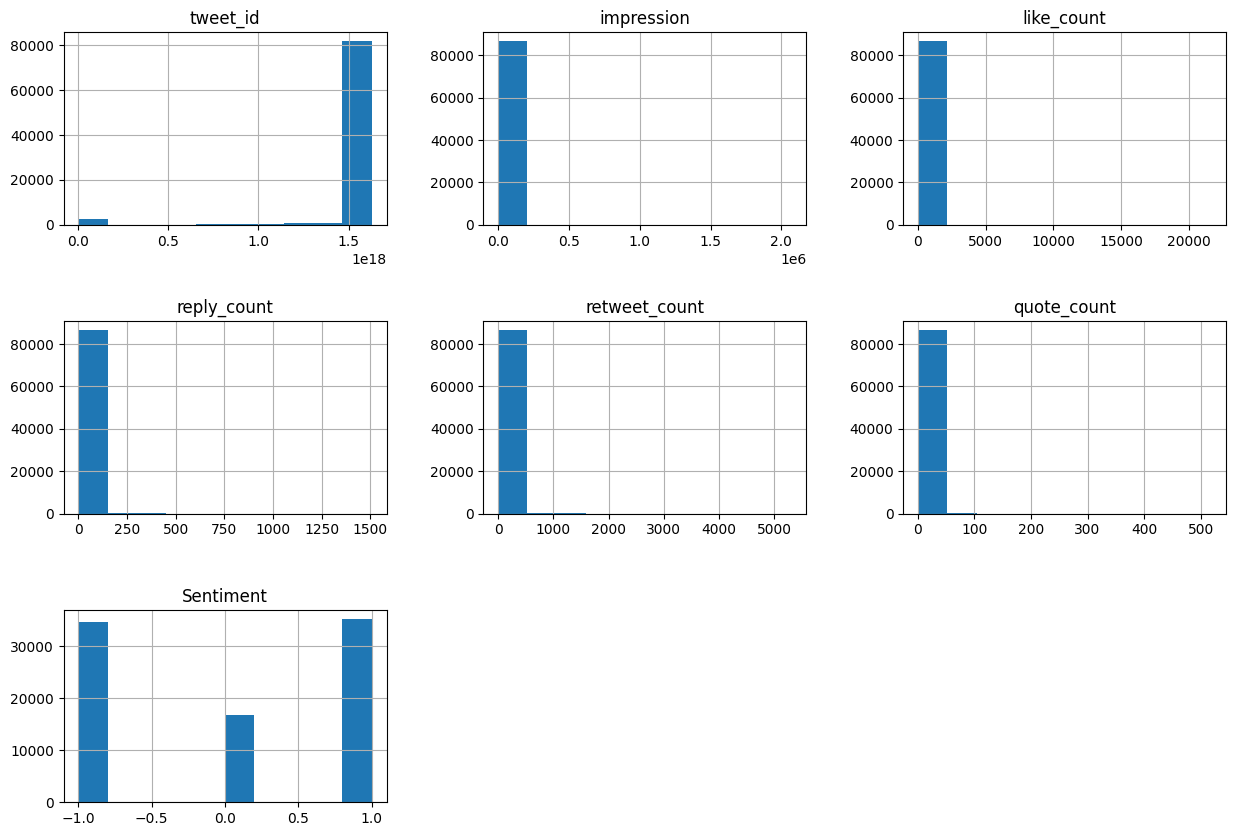

In [ ]:
# Plot the histogram
data.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

**Distribution of sentiment scores**

In [ ]:
data['Sentiment_polarity']

0        {'neg': 0.216, 'neu': 0.784, 'pos': ...
1        {'neg': 0.051, 'neu': 0.87, 'pos': 0...
2        {'neg': 0.0, 'neu': 1.0, 'pos': 0.0,...
3        {'neg': 0.0, 'neu': 1.0, 'pos': 0.0,...
4        {'neg': 0.0, 'neu': 0.786, 'pos': 0....
                          ...                   
98321    {'neg': 0.045, 'neu': 0.874, 'pos': ...
98322    {'neg': 0.064, 'neu': 0.851, 'pos': ...
98323    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0,...
98324    {'neg': 0.0, 'neu': 0.608, 'pos': 0....
98326    {'neg': 0.284, 'neu': 0.601, 'pos': ...
Name: Sentiment_polarity, Length: 86633, dtype: object

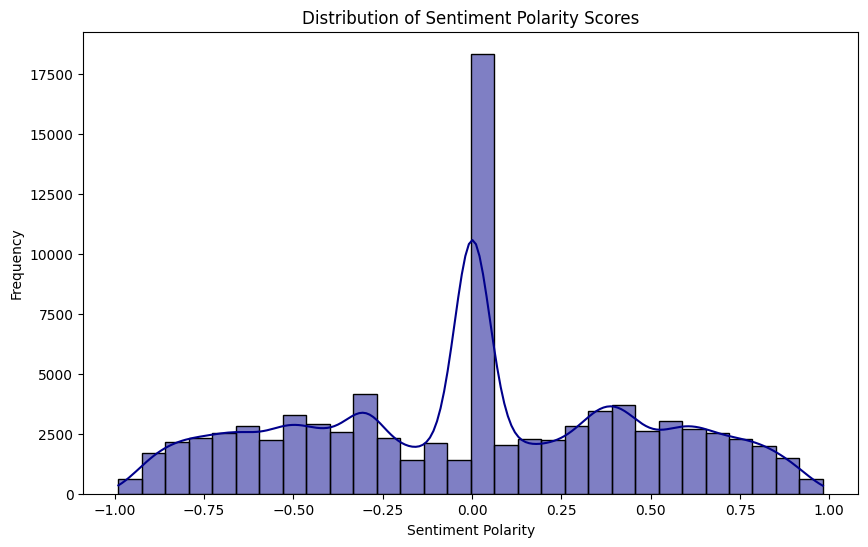

In [ ]:
# Extract 'compound' sentiment scores
compound_scores = data['Sentiment_polarity'].apply(lambda x: x['compound'])

# Plot the distribution of 'compound' sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(compound_scores, bins=30, kde=True, color='darkblue')
plt.title('Distribution of Sentiment Polarity Scores')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Analyze the overall sentiment landscape
positive_sentiment = len(data[data['Sentiment'] == 1])
neutral_sentiment = len(data[data['Sentiment'] == 0])
negative_sentiment = len(data[data['Sentiment'] == -1])

sentiment_summary = pd.DataFrame({'Sentiment': ['Positive', 'Neutral', 'Negative'],
                                  'Count': [positive_sentiment, neutral_sentiment, negative_sentiment]})
sentiment_summary


,Sentiment,Count
0,Positive,35272
1,Neutral,16761
2,Negative,34600


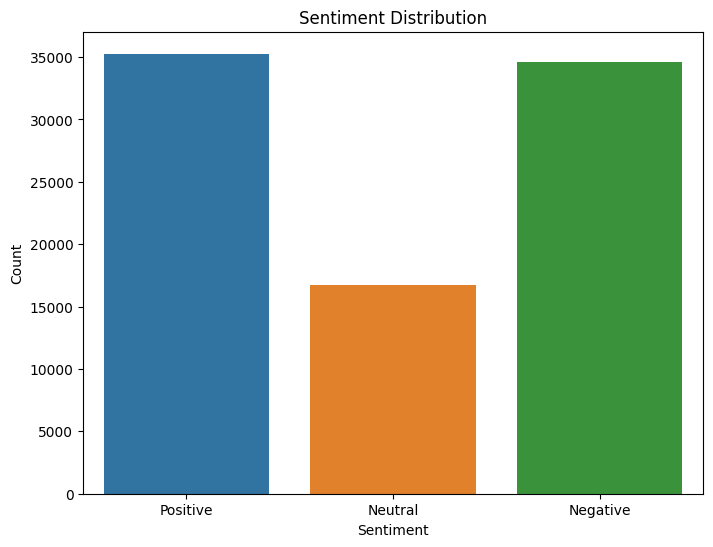

In [ ]:
# Visualize the sentiment summary
plt.figure(figsize=(8, 6))
sns.barplot(x='Sentiment', y='Count', data=sentiment_summary)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


**Top hashtags during the period**

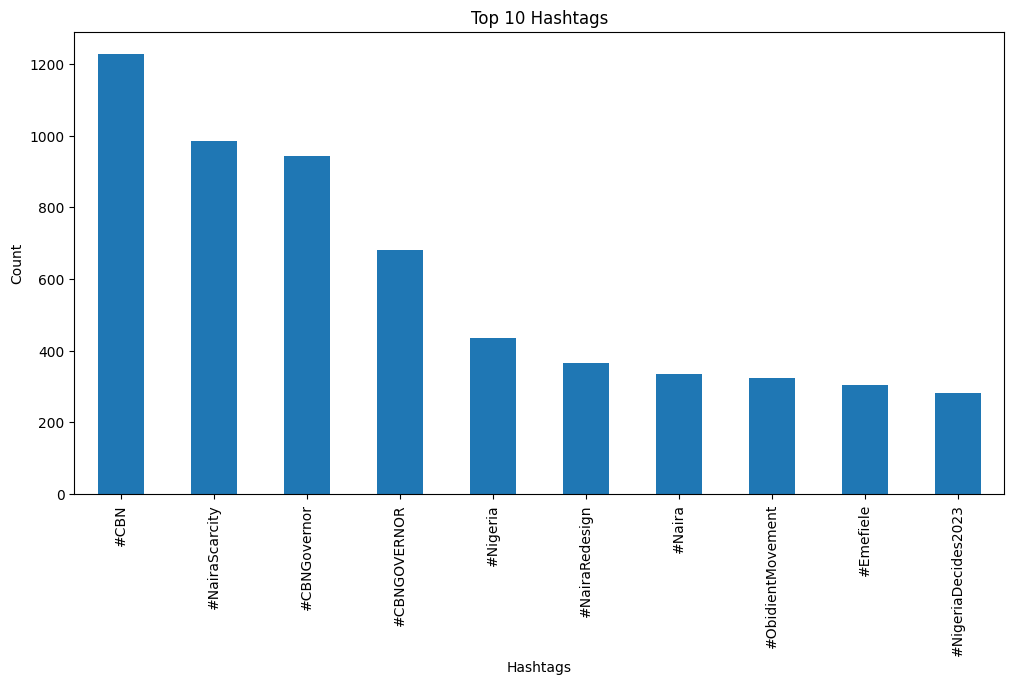

In [ ]:
# Extract hashtags from the 'Text' column
data['hashtags'] = data['Text content'].apply(lambda x: re.findall(r'#\w+', x))

# Plot hashtags over time
hashtags = [tag for sublist in data['hashtags'] for tag in sublist]
hashtag_counts = pd.Series(hashtags).value_counts()[:10]
plt.figure(figsize=(12, 6))
hashtag_counts.plot(kind='bar', title='Top 10 Hashtags')
plt.xlabel('Hashtags')
plt.ylabel('Count')
plt.show()

**Most common words used by Twitter Users to describe the policy during election**

In [ ]:
from nltk import pos_tag

# A function to obtain adjectives from tweets
def get_adjectives(text):
    # Convert string to tokens
    tokens = word_tokenize(text)

    # POS tagging
    adjectives = [word for (word, tag) in pos_tag(tokens) if tag.startswith("JJ")]

    # Join adjectives with spaces
    return " ".join(adjectives)


In [ ]:
data.to_csv('Tweets_Processed.csv',encoding='utf-8-sig', index=False)

In [ ]:
# Apply get_adjectives function to the new 'Processed Tweets' column
data['Users_perception'] = data['Processed_text'].apply(get_adjectives)

# Extract the 'Users_Perception' column to a list
users_perception = data['Users_perception'].tolist()

# Join the list elements into a single string
users_perception = " ".join(users_perception)


In [ ]:
data['Users_perception']

0           new kehinde fatinoye couple domestic
1        melancholic doltish narrative van co...
2                     affordable current thc usd
3                                       cashless
4                     benchmark monetary central
                          ...                   
98321                                ein wealthy
98322    many nigerian new electoral next nig...
98323                                      great
98324           grateful new happy atiku nigeria
98326                                       ipob
Name: Users_perception, Length: 86633, dtype: object

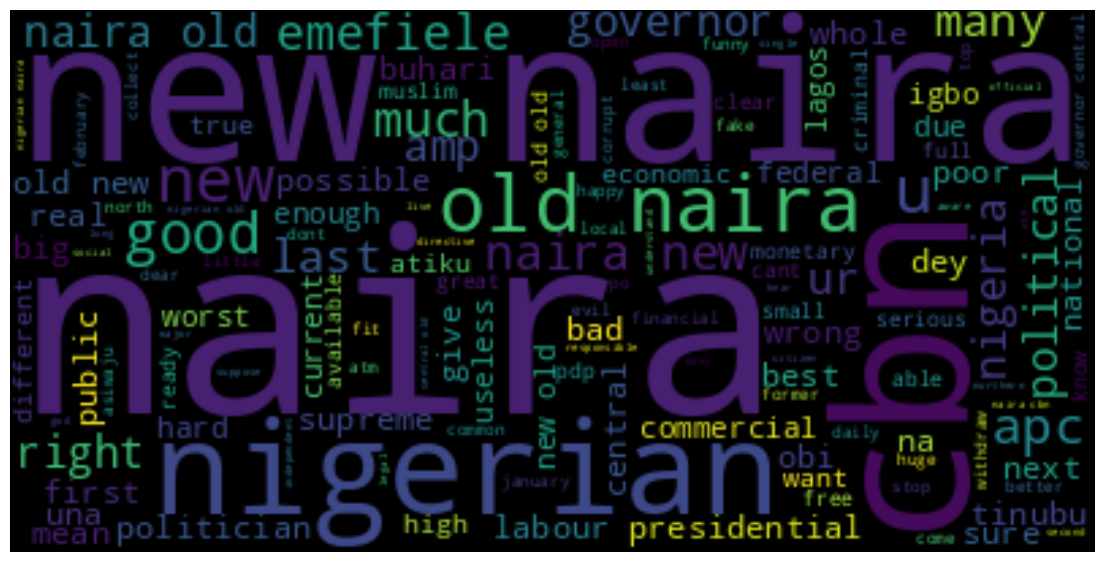

In [ ]:
# Instantiate the Word Cloud object
wc = WordCloud(background_color='black', max_words=2000, random_state=42)

# generate the word cloud
wc.generate(users_perception)

# display the word cloud
fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(18)

plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

## Balancing dataset

In [ ]:
X = data.drop(columns=["Sentiment"])

# Sentiment, the target variable
y = data["Sentiment"]

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Create a RandomUnderSampler instance
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Resample the data
X_resampled, y_resampled = rus.fit_resample(X, y)


In [ ]:
# Check the class distribution after undersampling
print("Class distribution after undersampling:")
print(y_resampled.value_counts())


Class distribution after undersampling:
-1    16761
 0    16761
 1    16761
Name: Sentiment, dtype: int64


## Sentiment Analysis Model Development

In [ ]:
# # Drop rows with "Neutral" in the "Sentiment" column
# filtered_data = data[data['Sentiment'] != 0]

### LSTM

In [ ]:
# Data preprocessing
max_words = 10000  # Maximum number of words to keep based on word frequency
max_len = 100  # Maximum length of a sequence

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_resampled['Processed_text'])
sequences = tokenizer.texts_to_sequences(X_resampled['Processed_text'])
X_encoded = pad_sequences(sequences, maxlen=max_len)

le = LabelEncoder()
y_transform = le.fit_transform(y_resampled)
y_encoded = to_categorical(y_transform)  # Convert to one-hot encoding

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

# Build the LSTM model
embedding_dim = 50  # Dimension of the embedding layer
hidden_units = 100  # Number of LSTM units

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(hidden_units))
model.add(Dense(len(le.classes_), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Make predictions
y_pred_probabilities = model.predict(X_test)


Epoch 1/5
1006/1006 [==============================] - 74s 71ms/step - loss: 0.6077 - accuracy: 0.7367 - val_loss: 0.3789 - val_accuracy: 0.8650
Epoch 2/5
1006/1006 [==============================] - 78s 77ms/step - loss: 0.2958 - accuracy: 0.8981 - val_loss: 0.3389 - val_accuracy: 0.8829
Epoch 3/5
1006/1006 [==============================] - 77s 76ms/step - loss: 0.2190 - accuracy: 0.9253 - val_loss: 0.3300 - val_accuracy: 0.8817
Epoch 4/5
1006/1006 [==============================] - 76s 76ms/step - loss: 0.1560 - accuracy: 0.9462 - val_loss: 0.3313 - val_accuracy: 0.8875
Epoch 5/5
315/315 [==============================] - 7s 21ms/step - loss: 0.3913 - accuracy: 0.8912
Accuracy: 0.8912200331687927
315/315 [==============================] - 7s 20ms/step


In [ ]:
y_pred_probabilities

array([[9.8759788e-01, 5.5852281e-03, 6.8169045e-03],
       [9.9987507e-01, 8.3427629e-05, 4.1450519e-05],
       [6.0488541e-02, 3.7070211e-02, 9.0244120e-01],
       ...,
       [5.0882544e-02, 9.8966109e-03, 9.3922085e-01],
       [1.6714527e-03, 1.9884431e-03, 9.9634016e-01],
       [7.8551834e-03, 5.2704117e-03, 9.8687440e-01]], dtype=float32)

In [ ]:
# Convert probabilities to labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)
y_pred_labels

array([0, 0, 2, ..., 2, 2, 2])

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      3381
           1       0.96      0.93      0.95      3368
           2       0.86      0.87      0.86      3308

    accuracy                           0.89     10057
   macro avg       0.89      0.89      0.89     10057
weighted avg       0.89      0.89      0.89     10057

Accuracy: 0.891220045739286
F1 Score: 0.89155111129752
Recall Score: 0.8910928170220473
Precision Score: 0.892292767379117


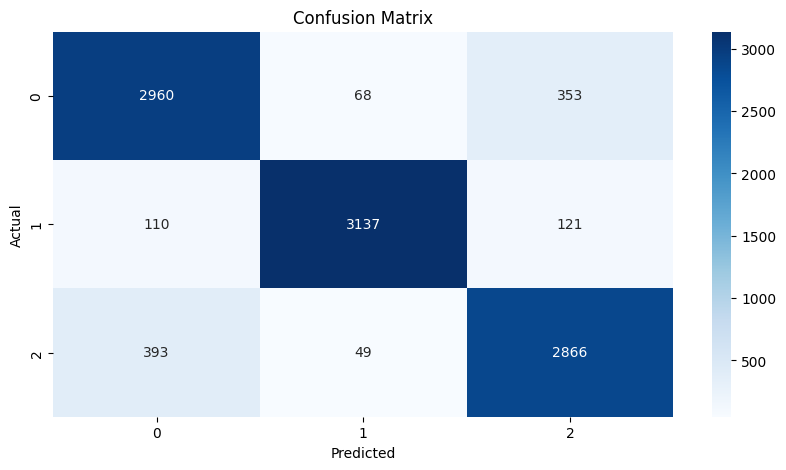

In [ ]:
# Evaluate the LSTM model

y_test_labels = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
classification_rep = classification_report(y_test_labels, y_pred_labels)

print("Classification Report:")
print(classification_rep)
print('Accuracy:', accuracy_score(y_test_labels, y_pred_labels))
print('F1 Score:', f1_score(y_test_labels, y_pred_labels, average='macro'))
print('Recall Score:', recall_score(y_test_labels, y_pred_labels, average='macro'))
print('Precision Score:', precision_score(y_test_labels, y_pred_labels, average='macro'))

# Create subplots
plt.figure(figsize=(10, 5))

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plots
plt.show()

### BERT

In [ ]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_resampled)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled['Processed_text'], y_encoded, test_size=0.2, random_state=42)

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))

# Tokenize and format the input data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128, return_tensors='pt')

# Create DataLoader
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Define training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 3)

# Training loop
num_epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

# Evaluation
model.eval()
all_preds = []
all_labels = []

for batch in test_loader:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    preds = torch.argmax(logits, dim=1).cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification Report:
              precision    recall  f1-score   support

          -1       0.93      0.95      0.94      3381
           0       0.99      0.96      0.97      3368
           1       0.93      0.93      0.93      3308

    accuracy                           0.95     10057
   macro avg       0.95      0.95      0.95     10057
weighted avg       0.95      0.95      0.95     10057

Accuracy: 0.9473003877895992
F1 Score: 0.9473910003282221
Recall Score: 0.947224376757334
Precision Score: 0.9477711483056739


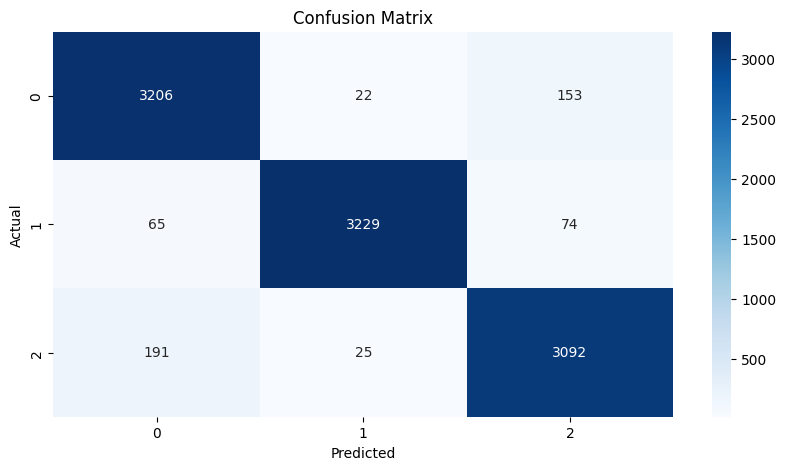

In [ ]:
# Decode labels
decoded_preds = le.inverse_transform(all_preds)
decoded_labels = le.inverse_transform(all_labels)

# Evaluate the results
conf_matrix = confusion_matrix(decoded_labels, decoded_preds)
classification_rep = classification_report(decoded_labels, decoded_preds)

print("Classification Report:")
print(classification_rep)
print('Accuracy:', accuracy_score(decoded_labels, decoded_preds))
print('F1 Score:', f1_score(decoded_labels, decoded_preds, average='macro'))
print('Recall Score:', recall_score(decoded_labels, decoded_preds, average='macro'))
print('Precision Score:', precision_score(decoded_labels, decoded_preds, average='macro'))

# Create subplots
plt.figure(figsize=(10, 5))

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plots
plt.show()
